#### Script that evalueates the synthetic profiles for the 4 types of profiles present

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions
from sklearn.metrics import mean_squared_error
import pickle
import scipy.stats
from scipy.stats import *

from support import *
from features.feature_ts import genX
from experiment.algorithms.cluster_prep import *
from Gauss_fit_functions import extractFIT, extractToPs , gauss, straight_line

from synthetic_profiles_functions import *

C:\Users\Jason\AppData\Local\Programs\Python\Python39\lib\os.py
c:\Users\Jason\thesis_project


In [2]:
X = genX([1994,2014],drop_0 = True)

dropping all zero rows


In [3]:
profileIDs = pd.read_pickle('ProfileIDs.pkl') # Read pickle file

## High Season Weekdays a.k.a. Winter Weekdays


In [31]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends

# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekdays), 'weekday')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekdays  = df_winter[df_winter['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_winter_weekdays.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekdays =  df_winter_weekdays[df_winter_weekdays.ProfileID.isin(profileIDs)]
# df_winter_weekdays.set_index(['ProfileID','date'], inplace=True)

# High Season Weekends a.k.a. Winter Weekends

In [32]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_winter = df[df['season'] == 'winter'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekends = ['Sunday', 'Saturday']
df_winter['day_names'] = df_winter.date.dt.day_name()
df_winter['daytype'] = df_winter.day_names.where(~df_winter.day_names.isin(weekends), 'weekend')
df_winter.drop(['day_names'], axis = 1, inplace = True)
df_winter_weekend  = df_winter[df_winter['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_winter_weekend.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_winter_weekend = df_winter_weekend[df_winter_weekend.ProfileID.isin(profileIDs)]

## Low Season Weekday a.k.a. Not Winter Weekday

In [33]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekdays), 'weekday')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekday  = df_summer[df_summer['daytype'] == 'weekday'] # Create dataframe with only weekdays
df_summer_weekday.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekday = df_summer_weekday[df_summer_weekday.ProfileID.isin(profileIDs)]

## Low Season Weekend a.k.a. Not Winter Weekend

In [34]:
# Collect only winter weekday profiles from dataset
df = X.copy()

df.reset_index(inplace = True)

# Extract Season
df['month'] = df.date.dt.month
df['season'] = df['month'].apply(lambda x: 'winter' if x in [6, 7, 8] else 'summer') 
df_summer = df[df['season'] == 'summer'] # Create dataframe with all the winter months, excluding weekends


# Extract Weekdays
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday','Friday']
weekends = ['Sunday', 'Saturday']
df_summer['day_names'] = df_summer.date.dt.day_name()
df_summer['daytype'] = df_summer.day_names.where(~df_summer.day_names.isin(weekends), 'weekend')
df_summer.drop(['day_names'], axis = 1, inplace = True)
df_summer_weekends  = df_summer[df_summer['daytype'] == 'weekend'] # Create dataframe with only weekdays
df_summer_weekends.drop(['month', 'season','daytype'], axis = 1, inplace = True)
df_summer_weekends = df_summer_weekends[df_summer_weekends.ProfileID.isin(profileIDs)]

# Load The Gauss Fit Features

## Low Season Weekdays

In [8]:
season = "Low_season_weekdays" #HighSeason_weekdays, Low_season_weekdays, Low_season_weekends, High_season_weekends


if season == "Low_season_weekdays":
    cleaned_df = df_summer_weekday.copy()

elif season == "Low_season_weekends":
    cleaned_df = df_summer_weekends.copy()

elif season == "HighSeason_weekdays":
    cleaned_df = df_winter_weekdays.copy()
    
elif season == "High_season_weekends":
    cleaned_df = df_winter_weekend.copy()


gaus_fit_features = pd.read_csv('FitFeatures_' + season + '.csv')
gauss_profileIds = gaus_fit_features['ProfileID'].unique()
cleaned_df_profile_ids = cleaned_df['ProfileID'].unique()

profileIDs_2 = np.intersect1d(gauss_profileIds, cleaned_df_profile_ids)

cleaned_df = cleaned_df.loc[cleaned_df.ProfileID.isin(profileIDs_2),:]
gauss_fit_features = gaus_fit_features.loc[gaus_fit_features.ProfileID.isin(profileIDs_2),:]

## Extract the Amplitudes from the measured profiles

In [10]:
# # Create cols
# cols = ['ProfileID','A1','A2','mu1','mu2']

# # Create dummy variables
# mu1 = 0
# A1 = 0 
# mu2 = 0
# A2 = 0

# data=[['DROP_ROW',A1,A2,mu1,mu2]]

# amplitudes_df = pd.DataFrame(data, columns=cols)

# profileIDs_3 = gauss_fit_features['ProfileID'].unique()

# for id in tqdm(profileIDs_3):
#     for index in cleaned_df[cleaned_df['ProfileID'] == id].index:
#         A1, A2, mu1, mu2, check = extractToPs(cleaned_df[cleaned_df['ProfileID'] == id].loc[index])
#         if check == False:
#             continue
        
#         data=[[id,A1,A2,mu1,mu2]]
#         temp_df = pd.DataFrame(data, columns=cols)
#         # temp_df.set_index(['ProfileID'])
#         amplitudes_df = amplitudes_df.append(temp_df)
    
# amplitudes_df = amplitudes_df.set_index(['ProfileID'])
# temporary = amplitudes_df.copy()
# temporary.drop(['DROP_ROW'],axis = 0, inplace = True)

  0%|          | 0/9111 [00:00<?, ?it/s]

# Save the amplitudes of the measured profiles to a csv file

In [9]:
# temporary.to_csv("Low_Season_weekdays_amplitudes.csv")
season_var = 'Low_Season_weekdays'

temporary = pd.read_csv(season_var+"_amplitudes.csv", index_col=['ProfileID'])

In [15]:
temporary

,A1,A2,mu1,mu2
ProfileID,,,,
1,4.966667,13.783333,7,21
1,5.450000,5.583333,6,15
1,2.441667,10.166667,3,20
1,5.391667,9.258334,7,21
1,6.450000,2.033333,7,17
...,...,...,...,...
12029036,2.950000,2.683333,5,19
12029036,3.483333,3.066667,4,17
12029036,2.883333,3.616667,5,19


In [10]:
def standard_deviation(my_list):
    #calculate population standard deviation of list 
    return (sum((x-(sum(my_list) / len(my_list)))**2 for x in my_list) / len(my_list))**0.5

In [11]:
daily_consumption = pd.DataFrame()

daily_consumption['Daily_Consumption'] = cleaned_df.set_index(["ProfileID"]).sum(axis = 1)

std_deviation_df = pd.DataFrame(index = temporary.index.unique())

for id in tqdm(temporary.index.unique()):
    try:
        std_deviation_df.loc[id,'A1_std'] = standard_deviation(temporary.loc[id]['A1'])
        std_deviation_df.loc[id,'A2_std'] = standard_deviation(temporary.loc[id]['A2'])
        std_deviation_df.loc[id,'mu1_std'] = standard_deviation(temporary.loc[id]['mu1'])
        std_deviation_df.loc[id,'mu2_std'] = standard_deviation(temporary.loc[id]['mu2'])
        std_deviation_df.loc[id,'DC_std'] = standard_deviation(daily_consumption.loc[id]['Daily_Consumption'])
    except TypeError:
        print('TypeError')
        continue

  0%|          | 0/9111 [00:00<?, ?it/s]

TypeError


In [12]:
gauss_fit_features.set_index(['ProfileID'], inplace = True)
combined_df = pd.merge(gauss_fit_features,std_deviation_df, left_index = True, right_index = True)

## Loop that extracts the distributions fitted to user profiles measured peaks

In [20]:
# profiles_ids = combined_df.index.unique().values

# cols = pd.MultiIndex.from_tuples([#("ProfileID",''),
#                                 ('A1', 'Distribution'),
#                                  ("A1", "chi_square"), 
#                                   ("A1", "params"), 
#                                   ("A2", "Distribution"),
#                                   ("A2", "chi_square"),
#                                   ("A2", "params") 
#                                   #, ('t1', 'Distribution'),
#                                   # ("t1", "chi_square"), 
#                                   # ("t1", "params"), 
#                                   # ("t2", "Distribution"),
#                                   # ("t2", "chi_square"),
#                                   # ("t2", "params"),
#                                 ])
# distributions_df = pd.DataFrame(index = profiles_ids,columns = cols)
# results = []
# for id in tqdm(profiles_ids):
#     # Extract the best distribution fitted
#     try:
#       results1 = fit_distribution(temporary.loc[id],'A1',0.99,0.01)
#       results2 = fit_distribution(temporary.loc[id],'A2',0.99,0.01)
#       # results3 = fit_distribution(temporary.loc[id],'mu1',0.99,0.01)
#       # results4 = fit_distribution(temporary.loc[id],'mu2',0.99,0.01)

#       results = [results1.values[0],results1.values[1],results1.values[2], results2.values[0],results2.values[1],results2.values[2]]
#                 # ,results3.values[0],results3.values[1],results3.values[2], results4.values[0],results4.values[1],results4.values[2]]

#       distributions_df.loc[id] = results
#     except Exception:
#       continue

  0%|          | 0/9111 [00:00<?, ?it/s]

In [13]:
# distributions_df.to_csv('Low_Season_Weekday_Distributions.csv')
season_var = 'Low_Season_Weekday'

distributions_df = pd.read_csv(season_var +'_Distributions.csv', header = [0,1], index_col = 0).dropna()


# Loop that generates the synthetic peaks from the fitted distributions

In [14]:
level_0 = distributions_df.columns.get_level_values(0).unique()
inv_data_df = pd.DataFrame()
temp_df_inv = pd.DataFrame()
for houseID in tqdm(distributions_df.index):
    for column in level_0:

        distributions = distributions_df[column].loc[houseID]['Distribution']
        parameters = distributions_df[column].loc[houseID]['params']
        parameters = eval(parameters)
        loc = combined_df.loc[houseID][column] + combined_df.loc[houseID]['H_offset']
        scale = combined_df.loc[houseID][column + '_std']  
        # loc = parameters[-2]
        # scale = parameters[-1]
        size = len(cleaned_df[cleaned_df['ProfileID'] == houseID])

        if distributions == 'invgauss':
            print('invgauss')
            data_points = invgauss.rvs(parameters[0],loc = loc,scale = scale,size = size)
        elif distributions == 'weibull_min':
            print('weibull_min')
            data_points = weibull_min.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'weibull_max':
            print('weibull_max')
            print(f'loc = {loc}, scale = {scale}')
            data_points = weibull_max.rvs(parameters[0], loc = loc, scale = scale, size = size)
            # data_points = weibull_max.rvs(parameters[0], parameters[1], parameters[2], size = 60)
        elif distributions == 'beta':
            print('beta')
            data_points = beta.rvs(parameters[0], parameters[1], loc = loc,scale = scale, size = size)
            # data_points = beta.rvs(parameters[0], parameters[1], parameters[2],parameters[3], size = 60)
        elif distributions == 'norm':
            print('norm')
            data_points = norm.rvs(parameters[0], parameters[1], size = size)
        elif distributions == 'triang':
            print('triang')
            data_points = triang.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'pearson3':
            print('pearson3')
            data_points = pearson3.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'lognorm':
            print('lognorm')
            data_points = lognorm.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'uniform':
            print('uniform')
            data_points = uniform.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'expon':
            print('expon')
            data_points = expon.rvs(loc = loc,scale = scale, size = size)
        elif distributions == 'gamma':
            print('gamma')
            data_points = gamma.rvs(parameters[0], loc = loc,scale = scale, size = size)
        elif distributions == 'alpha':
            print('alpha')
            data_points = alpha.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'arcsine':
            print('arcsine')
            data_points = arcsine.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'cauchy':
            print('cauchy')
            data_points = cauchy.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'dweibull':
            print('dweibull')
            data_points = dweibull.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'exponnorm':
            print('exponnorm')
            data_points = exponnorm.rvs(K=1.5, loc=loc, scale = scale,size=size)
        elif distributions == 'halflogistic':
            print('halflogistic')
            data_points = halflogistic.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'logistic':
            print('logistic')
            data_points = logistic.rvs(loc=loc, scale = scale,size=size)
        elif distributions == 'loggamma':
            print('loggamma')
            data_points = loggamma.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'powerlaw':
            print('powerlaw')
            data_points = powerlaw.rvs(parameters[0], loc=loc, scale = scale,size=size)
        elif distributions == 'powernorm':
            print('powernorm')
            data_points = powernorm.rvs(parameters[0], loc=loc, scale = scale,size=size)
        

        # print(column)
        # inverse_data_points = inverse_StandardScalar(data_points,temporary.loc[id],column,0.99,0.01)
        temp_df_inv['ProfileID'] = houseID
        temp_df_inv[column] = data_points#inverse_data_points
        
    inv_data_df = inv_data_df.append(temp_df_inv)
    temp_df_inv = pd.DataFrame()
        # if column == 'A1':
        #     data_pointA1 = data_points#inverse_data_points
        # elif column == 'A2':
        #     data_pointsA2 = data_points#inverse_data_points

inv_data_df = inv_data_df.dropna()
inv_data_df.set_index(['ProfileID'], inplace = True)

  0%|          | 0/9108 [00:00<?, ?it/s]

halflogistic
weibull_min
weibull_min
invgauss
invgauss
gamma
weibull_min
weibull_min
invgauss
invgauss
invgauss
invgauss
weibull_min
invgauss
halflogistic
lognorm
invgauss
weibull_min
weibull_min
weibull_min
invgauss
lognorm
invgauss
weibull_min
lognorm
lognorm
lognorm
invgauss
lognorm
invgauss
invgauss
weibull_min
lognorm
weibull_min
weibull_min
weibull_min
weibull_min
lognorm
invgauss
lognorm
lognorm
invgauss
invgauss
lognorm
invgauss
gamma
invgauss
invgauss
invgauss
invgauss
lognorm
invgauss
invgauss
invgauss
lognorm
lognorm
weibull_min
weibull_min
invgauss
gamma
invgauss
lognorm
weibull_min
weibull_min
lognorm
halflogistic
gamma
lognorm
halflogistic
invgauss
gamma
lognorm
weibull_min
invgauss
weibull_min
halflogistic
gamma
invgauss
invgauss
invgauss
halflogistic
weibull_min
invgauss
weibull_min
lognorm
lognorm
invgauss
weibull_min
lognorm
weibull_min
invgauss
weibull_min
lognorm
lognorm
weibull_min
invgauss
invgauss
weibull_min
weibull_min
invgauss
weibull_min
invgauss
invgauss
inv

# Loop That creates the synthetic Profiles

In [39]:

# # Function that generates synthetic profiles
# def generate_synth_profiles1(id,A1,A2,mu1,mu2, H_offset, sigma1, sigma2, sigma3, sigma4):    
#     # Straight line approximation between: mu1 + 4 to mu2 - 4
#     # Determine the complete synthetic profile
    
#     i = 0
#     temp = pd.DataFrame()
#     for A1_item, A2_item in zip(A1.A1.iteritems(), A2.A2.iteritems()):
#         integer = 3
#         x_1 = np.arange(0,mu1,1)
#         x_2 = np.arange(mu1,mu1+integer,1)
#         x_3 = np.arange(mu2-integer,mu2,1)
#         x_4 = np.arange(mu2,24,1)

#         x_vals = np.hstack((x_1,x_2,x_3,x_4))

#         if len(x_vals) > 24:
#             integer = integer - 1
#             x_1 = np.arange(0,mu1,1)
#             x_2 = np.arange(mu1,mu1+integer,1)
#             x_3 = np.arange(mu2-integer,mu2,1)
#             x_4 = np.arange(mu2,24,1)
#             x_vals = np.hstack((x_1,x_2,x_3,x_4))
#         # print(f"integer == {integer}")    

#         x_vals_1 = np.unique(x_vals)
#         # if id == 3268:
#         # print(f"mu1 = {mu1}")
#         # print(f"mu2 = {mu2}")
#         # print(f"x_1 = {x_1}, x2 = {x_2}, x_3 = {x_3}, x4 = {x_4}")
#         # print(f"x_vals = {x_vals_1}")
#         # synthetic_df2 = pd.DataFrame()
        
#         i = i + 1
#         gauss1 = gauss(x_1, H_offset ,A1_item[1], mu1, sigma1)
#         gauss2 = gauss(x_2, H_offset ,A1_item[1], mu1, sigma2)
#         gauss3 = gauss(x_3, H_offset ,A2_item[1], mu2, sigma3)
#         gauss4 = gauss(x_4, H_offset ,A2_item[1], mu2, sigma4)
#         # print(A1_item[1])
#         # if id == 3268:
#         # print(f'len(gauss1) = {len(gauss1)}')
#         # print(f'len(gauss2) = {len(gauss2)}')
#         # print(f'len(gauss3) = {len(gauss3)}')
#         # print(f'len(gauss4) = {len(gauss4)}')
#         i2 = mu1 + integer
#         i3 = mu2 - integer
#         # print(f"i2 = {i2}, i3 = {i3}")
#         if len(x_vals) == 24:
#                 # print("Entire array is captured")
#                 if x_2[-1] == x_3[0]:
#                     x_3 = x_3[1:] # Remove the first value of the x-array
#                     y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
#                     synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
#                 else:
#                     synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values

#         elif len(x_vals) < 24:
#             # print("Missing hours need to be saved")
#             x_5 = np.arange(i2,i3,1)
#             x_vals_1 = np.hstack((x_1,x_2,x_5,x_3,x_4))
#             x_vals_1 = np.unique(x_vals_1)
#             if len(x_5) == 1:
#                 y_mid = np.abs(gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2) - gauss(x_5[0], H_offset,A2_item[1],mu2,sigma3))/2

#             else:    
#                 # Synthesize the mid range behaviour
#                 m = (gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - gauss(x_5[0], H_offset,A1_item[1],mu1,sigma2))/(x_5[-1]-x_5[0]) # Calculate slope
#                 b = gauss(x_5[-1], H_offset,A2_item[1],mu2,sigma3) - m*x_5[-1] # Calculate b constant for straight line equation
#                 y_mid = straight_line(m,x_5,b)
                
#             synth = np.hstack((gauss1,gauss2,y_mid,gauss3,gauss4))
#             # if id == 3268:

#         elif len(x_vals) > 24:    
#             if x_2[-1] == x_3[0]:
#                 x_3 = x_3[1:] # Remove the first value of the x-array
#                 y3 = gauss(x_3, H_offset,A2_item[1],mu2,sigma3) # Re-calculate the y-values for gauss 3
#                 synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # Generate the synthetic values
#                 # print(x_3)
#             else:
#                 synth = np.hstack((gauss1,gauss2,gauss3,gauss4)) # If there is no repeating values in x_2 and x_3 then generate synthetic profiles without adjusting x_3's values


#         values = synth.tolist()
#         df = pd.DataFrame(values)
#         df = df.T
#         temp = temp.append(df)


#     temp['ProfileID'] = id
#     temp.set_index(['ProfileID'], inplace = True)        

#     return temp

In [41]:
# synthetic_df = pd.DataFrame()
# for id in tqdm(distributions_df.index.unique()):
#     houseID = id

#     H_offset = combined_df.loc[houseID]['H_offset']
#     # H_offset = 0.0
#     mu1 = combined_df.loc[houseID]['mu1']
#     mu2 = combined_df.loc[houseID]['mu2']

#     sigma1 = combined_df.loc[houseID]['sigma1']
#     sigma2 = combined_df.loc[houseID]['sigma2']
#     sigma3 = combined_df.loc[houseID]['sigma3']
#     sigma4 = combined_df.loc[houseID]['sigma4']

#     A1 = inv_data_df.loc[houseID]['A1']
#     A2 = inv_data_df.loc[houseID]['A2']
#     A1 = pd.DataFrame(A1)
#     A2 = pd.DataFrame(A2)
#     A1 = A1 - H_offset
#     A2 = A2 - H_offset

#     A1.reset_index(inplace=True)
#     A2.reset_index(inplace=True)


#     synth = generate_synth_profiles1(houseID,A1,A2,mu1,mu2,H_offset,sigma1,sigma2, sigma3,sigma4)

#     # temp = pd.DataFrame(synth)
#     # temp = temp.T
#     synthetic_df = synthetic_df.append(synth)
#     synthetic_df

In [29]:
# synthetic_df_temp = synthetic_df.reset_index()
# synthetic_df_mean = synthetic_df_temp.groupby(['ProfileID']).mean()
# synthetic_df_mean.drop(synthetic_df_mean.columns[[-1]], axis = 1, inplace = True)

In [31]:
# def mean_absolute_percentage_error(y_true, y_pred): 
#     y_true, y_pred = np.array(y_true), np.array(y_pred)
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# def smape(a, f):
#     return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

In [32]:
# cols = ['ProfileID','RMSE', 'sMAPE', 'MAPE']

# errors = pd.DataFrame(columns = cols)

# for houseID in tqdm(synthetic_df_mean.index):

#     # Measured Mean profile
#     actual = cleaned_df[cleaned_df["ProfileID"] == houseID]
#     actual = actual.groupby(['ProfileID']).mean().values[0]

#     # predicted = synthetic_df_temp[synthetic_df_temp['ProfileID'] == houseID]
#     predicted = synthetic_df_mean.loc[houseID]

#     MSE = mean_squared_error(actual, predicted)
#     RMSE = math.sqrt(MSE)
#     MAPE = mean_absolute_percentage_error(actual, predicted)
#     sMAPE = smape(actual, predicted)

#     data = [[houseID, RMSE,sMAPE,MAPE]]
#     temp = pd.DataFrame(data, columns = cols)
#     errors = errors.append(temp)

# errors.set_index(['ProfileID'], inplace = True)
# # errors.to_csv('Errors_of_synth_vs_actual.csv')


  0%|          | 0/9111 [00:00<?, ?it/s]

In [31]:
# errors = pd.read_csv("Errors_of_synth_vs_actual.csv", index_col=['ProfileID'])
# errors
# # Filter out all households with an sMAPE higher than 35%
# profile_ids_good_fit = errors[errors['sMAPE'] < 35.0].index.values

# Plot Distributions of the Peaks

### First filter out any outliers

In [15]:
def Remove_Outlier_Indices(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.95)
    IQR = Q3 - Q1
    trueList = ~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR)))
    return trueList

In [16]:
synthetic_peaks_filtered = inv_data_df#.loc[inv_data_df.index.isin(profile_ids_good_fit),:]
synthetic_peaks_filtered.reset_index(inplace = True)


synthetic_peaks_filtered_temp = synthetic_peaks_filtered[Remove_Outlier_Indices(synthetic_peaks_filtered['A1'])]
synthetic_peaks_filtered_temp = synthetic_peaks_filtered_temp[Remove_Outlier_Indices(synthetic_peaks_filtered_temp['A2'])]

In [28]:
# synthetic_peaks_filtered = inv_data_df.loc[inv_data_df.index.isin(profile_ids_good_fit),:]
# synthetic_peaks_filtered.reset_index(inplace = True)
# ''' Detection '''
# # IQR
# Q1 = np.percentile(synthetic_peaks_filtered['A1'], 0,
#                    interpolation = 'midpoint')
 
# Q3 = np.percentile(synthetic_peaks_filtered['A1'], 90,
#                    interpolation = 'midpoint')
# IQR = Q3 - Q1
 
# print("Old Shape: ", synthetic_peaks_filtered.shape)
 
# # Upper bound
# upper = np.where(synthetic_peaks_filtered['A1'] >= (Q3+1.5*IQR))
# # Lower bound
# lower = np.where(synthetic_peaks_filtered['A1'] <= (Q1-1.5*IQR))
 
# ''' Removing the Outliers '''
# synthetic_peaks_filtered.drop(upper[0], inplace = True)
# synthetic_peaks_filtered.drop(lower[0], inplace = True)
 
# print("New Shape: ", synthetic_peaks_filtered.shape)

## Plot distribution of peaks

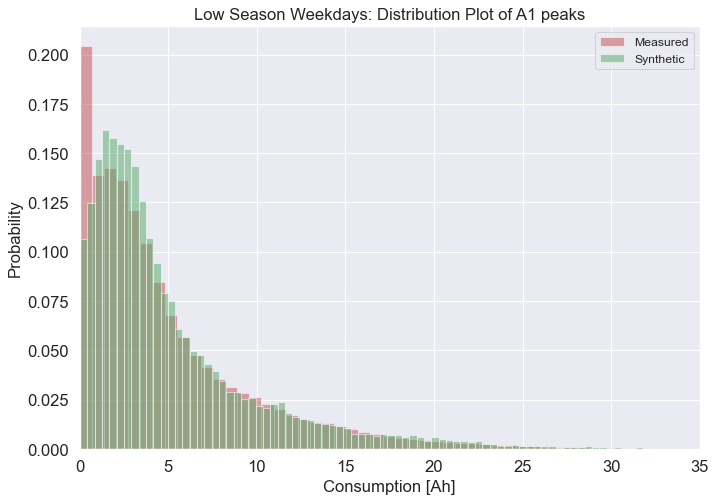

In [37]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered.ProfileID.unique()),:]
# synthetic_peaks_filtered = inv_data_df.loc[inv_data_df.index.isin(profile_ids_good_fit),:]

act_A1 = measured_peaks_filtered['A1']
# act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
# synth_A2 = synthetic_peaks_filtered['A2']

# Normalize
kwargs = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.rcParams.update({'font.size': 15})
plt.hist(act_A1, **kwargs, color='r', label='Measured')
plt.hist(synth_A1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of A1 peaks', ylabel='Probability')
plt.title('Low Season Weekdays: Distribution Plot of A1 peaks', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

plt.xlim(0,35)
plt.legend();

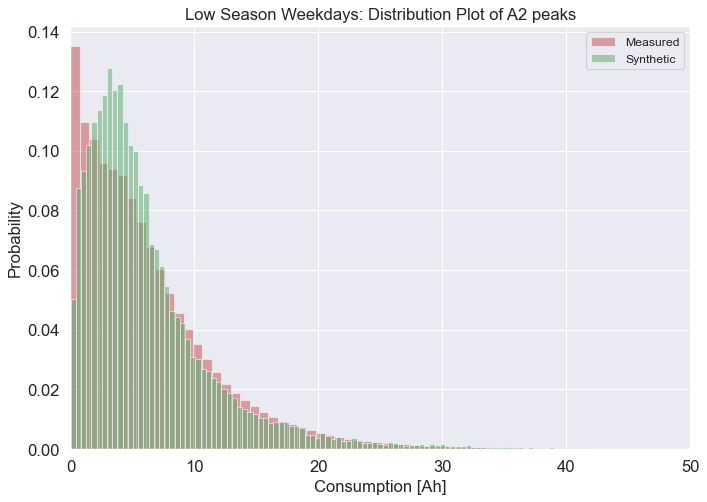

In [38]:
# act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
# synth_A1 = synthetic_peaks_filtered['A1']
synth_A2 = synthetic_peaks_filtered_temp['A2']

# Normalize
kwargs1 = dict(alpha=0.5, bins=100, density=True, stacked=True)
kwargs2 = dict(alpha=0.5, bins=100, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(act_A2, **kwargs1, color='r', label='Measured')
plt.hist(synth_A2, **kwargs2, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of A2 peaks', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('Low Season Weekdays: Distribution Plot of A2 peaks', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
# plt.rcParams.update({'font.size': 50})
plt.xlim(0,50)
plt.legend();

### Plot Daily Consumption Distribution

In [42]:
# season = "High_season_weekends" #HighSeason_weekdays, Low_season_weekdays, Low_season_weekends, High_season_weekends
def get_FitFeatures(season):

    if season == "Low_season_weekdays":
        cleaned_df = df_summer_weekday.copy()

    elif season == "Low_season_weekends":
        cleaned_df = df_summer_weekends.copy()

    elif season == "HighSeason_weekdays":
        cleaned_df = df_winter_weekdays.copy()
        
    elif season == "High_season_weekends":
        cleaned_df = df_winter_weekend.copy()


    gaus_fit_features = pd.read_csv('FitFeatures_' + season + '.csv')
    gauss_profileIds = gaus_fit_features['ProfileID'].unique()
    cleaned_df_profile_ids = cleaned_df['ProfileID'].unique()

    profileIDs_2 = np.intersect1d(gauss_profileIds, cleaned_df_profile_ids)

    cleaned_df = cleaned_df.loc[cleaned_df.ProfileID.isin(profileIDs_2),:]
    gauss_fit_features = gaus_fit_features.loc[gaus_fit_features.ProfileID.isin(profileIDs_2),:]

    return cleaned_df, gauss_fit_features

In [37]:
Synth_Prof_HWeekend = pd.read_csv("CSV_Exclude/Synth_Profiles_HWeekend.csv", index_col = 'ProfileID')
Synth_Prof_HWeekday = pd.read_csv("CSV_Exclude/Synth_Profiles_HWeekday.csv", index_col = 'ProfileID')
Synth_Prof_LWeekday = pd.read_csv("CSV_Exclude/Synth_Profiles_LWeekday.csv", index_col = 'ProfileID')
Synth_Prof_LWeekend = pd.read_csv("CSV_Exclude/Synth_Profiles_LWeekend.csv", index_col = 'ProfileID')

In [21]:
# daily_energy_synth = Synth_Prof_LWeekday.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
# daily_energy_synth.reset_index(inplace = True)

# # # IQR
# # Q1 = np.percentile(daily_energy_synth['Daily Energy'], 0,
# #                    interpolation = 'midpoint')
 
# # Q3 = np.percentile(daily_energy_synth['Daily Energy'], 90,
# #                    interpolation = 'midpoint')
# # IQR = Q3 - Q1
 
# # print("Old Shape: ", daily_energy_synth.shape)
 
# # # Upper bound
# # upper = np.where(daily_energy_synth['Daily Energy'] >= (Q3+1.5*IQR))
# # # Lower bound
# # lower = np.where(daily_energy_synth['Daily Energy'] <= (Q1-1.5*IQR))
 
# # ''' Removing the Outliers '''
# # daily_energy_synth.drop(upper[0], inplace = True)
# # daily_energy_synth.drop(lower[0], inplace = True)
 
# # print("New Shape: ", daily_energy_synth.shape)

### Low Season Weekdays

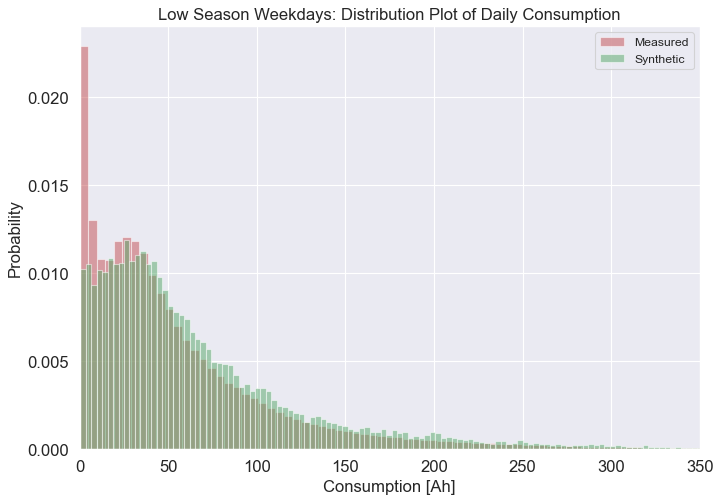

In [43]:
cleaned_df, gauss_fit_features = get_FitFeatures(season = "Low_season_weekdays")

daily_energy_synth = Synth_Prof_LWeekday.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)


new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=200, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('Low Season Weekdays: Distribution Plot of Daily Consumption', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.xlim(0,350)
plt.legend();

### Low Season Weekends

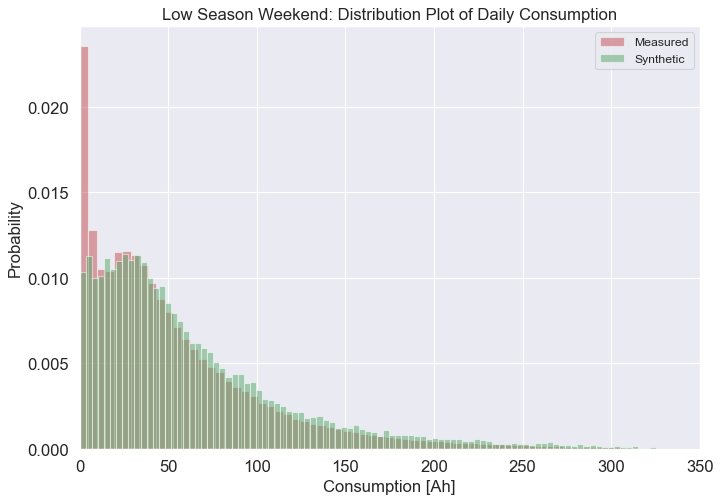

In [44]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "Low_season_weekends")

daily_energy_synth = Synth_Prof_LWeekend.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=200, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('Low Season Weekend: Distribution Plot of Daily Consumption', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.xlim(0,350)
plt.legend();


### High Season Weekdays

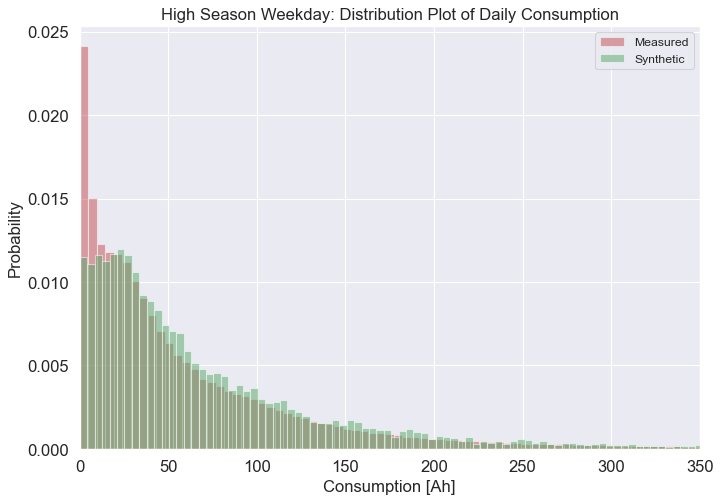

In [45]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "HighSeason_weekdays")

daily_energy_synth = Synth_Prof_HWeekday.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=200, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('High Season Weekday: Distribution Plot of Daily Consumption', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.xlim(0,350)
plt.legend();


### High Season Weekend

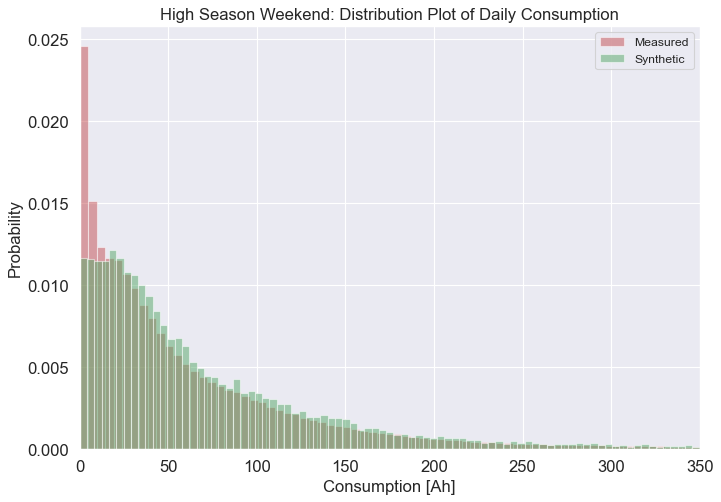

In [46]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "High_season_weekends")

daily_energy_synth = Synth_Prof_HWeekend.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=200, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
# plt.gca().set(title='Low Season Weekdays: Distribution Plot of Daily Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.title('High Season Weekend: Distribution Plot of Daily Consumption', fontsize = 15)
plt.ylabel('Probability', fontsize = 15)
plt.xlabel('Consumption [Ah]', fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)
plt.xlim(0,350)
plt.legend();

## Aggregate Consumption

In [102]:
len(daily_energy_actual.ProfileID.unique())

9789

In [101]:
len(daily_energy_synth.ProfileID.unique())

9660

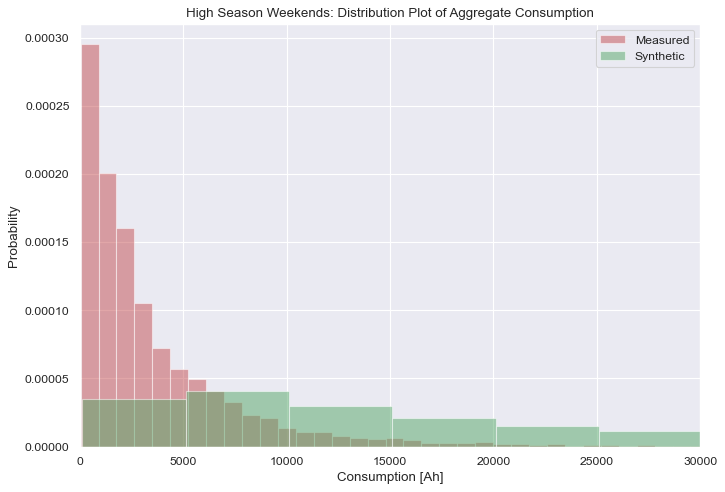

In [105]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "HighSeason_weekdays")

daily_energy_synth = Synth_Prof_HWeekday.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000
x2 = daily_energy_actual_filtered.groupby(['ProfileID'])['Daily Energy'].sum()#*230/1000

# Normalize
kwargs = dict(alpha=0.5, bins=50, density=True, stacked=True)

# Plot
plt.figure(figsize=(10,7), dpi= 80)
plt.hist(x2, **kwargs, color='r', label='Measured')
plt.hist(x1, **kwargs, color='g', label='Synthetic')
# plt.hist(x3, **kwargs, color='r', label='Good')
plt.gca().set(title='High Season Weekends: Distribution Plot of Aggregate Consumption', ylabel='Probability')
plt.xlabel('Consumption [Ah]')
plt.xlim(0,30000)
plt.legend();

# Boxplots

In [23]:
act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
synth_A2 = synthetic_peaks_filtered_temp['A2']

In [24]:
# act_A1_percentiles = np.percentile(act_A1, [25, 50, 75])
# act_A2_percentiles = np.percentile(act_A2, [25, 50, 75])
# synth_A1_percentiles = np.percentile(synth_A1, [25, 50, 75])
# synth_A2_percentiles = np.percentile(synth_A2, [25, 50, 75])

# # MSE = mean_squared_error(actual, predicted)
# # RMSE = math.sqrt(MSE)
# # sMAPE = smape(actual, predicted)

# A1_25_RMSE = np.abs(act_A1_percentiles[0] - synth_A1_percentiles[0])/act_A1_percentiles[0]*100
# A1_50_RMSE = np.abs(act_A1_percentiles[1] - synth_A1_percentiles[1])/act_A1_percentiles[1]*100
# A1_75_RMSE = np.abs(act_A1_percentiles[2] - synth_A1_percentiles[2])/act_A1_percentiles[2]*100
# A2_25_RMSE = np.abs(act_A2_percentiles[0] - synth_A2_percentiles[0])/act_A2_percentiles[0]*100
# A2_50_RMSE = np.abs(act_A2_percentiles[1] - synth_A2_percentiles[1])/act_A2_percentiles[1]*100
# A2_75_RMSE = np.abs(act_A2_percentiles[2] - synth_A2_percentiles[2])/act_A2_percentiles[2]*100

# Percentiles A1
act_A1_25th = measured_peaks_filtered.describe().loc['25%']['A1']
act_A1_50th = measured_peaks_filtered.describe().loc['50%']['A1']
act_A1_75th = measured_peaks_filtered.describe().loc['75%']['A1']

synth_A1_25th = synthetic_peaks_filtered_temp.describe().loc['25%']['A1']
synth_A1_50th = synthetic_peaks_filtered_temp.describe().loc['50%']['A1']
synth_A1_75th = synthetic_peaks_filtered_temp.describe().loc['75%']['A1']

# Percentiles A2
act_A2_25th = measured_peaks_filtered.describe().loc['25%']['A2']
act_A2_50th = measured_peaks_filtered.describe().loc['50%']['A2']
act_A2_75th = measured_peaks_filtered.describe().loc['75%']['A2']

synth_A2_25th = synthetic_peaks_filtered_temp.describe().loc['25%']['A2']
synth_A2_50th = synthetic_peaks_filtered_temp.describe().loc['50%']['A2']
synth_A2_75th = synthetic_peaks_filtered_temp.describe().loc['75%']['A2']

# Percentage Error A1
A1_25_RMSE = np.abs(act_A1_25th - synth_A1_25th)/act_A1_25th*100
A1_50_RMSE = np.abs(act_A1_50th - synth_A1_50th)/act_A1_50th*100
A1_75_RMSE = np.abs(act_A1_75th - synth_A1_75th)/act_A1_75th*100

# Percentage Error A2
A2_25_RMSE = np.abs(act_A2_25th - synth_A2_25th)/act_A2_25th*100
A2_50_RMSE = np.abs(act_A2_50th - synth_A2_50th)/act_A2_50th*100
A2_75_RMSE = np.abs(act_A2_75th - synth_A2_75th)/act_A2_75th*100

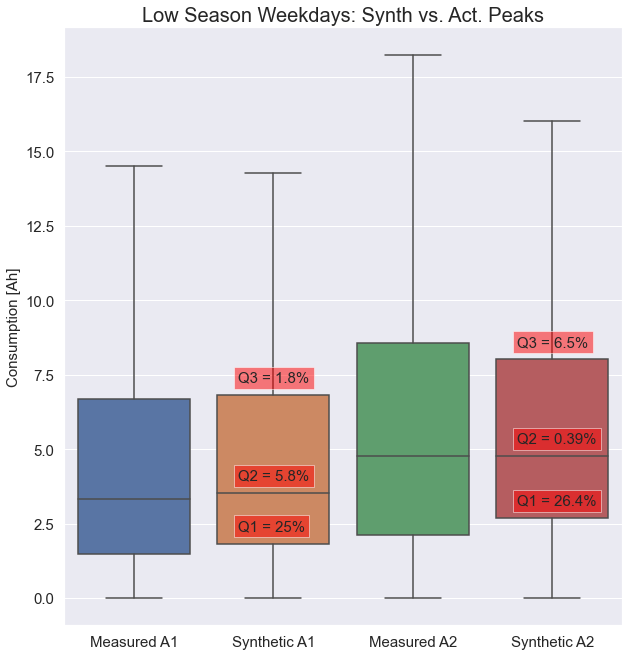

In [27]:
act_A1 = measured_peaks_filtered['A1']#*230/1000
act_A2 = measured_peaks_filtered['A2']#*230/1000
synth_A1 = synthetic_peaks_filtered_temp['A1']#*230/1000
synth_A2 = synthetic_peaks_filtered_temp['A2']#*230/1000

data_to_plot = [act_A1,synth_A1,act_A2,synth_A2]
# sns.set(font_scale=2)
ax = sns.boxplot(data=data_to_plot, showfliers = False)


q1_A1 = synth_A1.quantile(0.25) + 0.45
q2_A1 = synth_A1.quantile(0.5) + 0.45
q3_A1 = synth_A1.quantile(0.75) + 0.45

q1_A2 = synth_A2.quantile(0.25) + 0.45
q2_A2 = synth_A2.quantile(0.5) + 0.45
q3_A2 = synth_A2.quantile(0.75) + 0.45
# Box 1
# 25th Percentile
plt.text(0.75, q1_A1,
         'Q1 = ' + str('{0:.2g}').format(A1_25_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 50th Percentile
plt.text(0.75, q2_A1,
         'Q2 = ' + str('{0:.2g}').format(A1_50_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 75th Percentile
plt.text(0.75, q3_A1,
         'Q3 = ' + str('{0:.2g}').format(A1_75_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# Box 3
# 25th Percentile
plt.text(2.75, q1_A2,
         'Q1 = ' + str('{0:.3g}').format(A2_25_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 50th Percentile
plt.text(2.75, q2_A2,
         'Q2 = ' + str('{0:.2g}').format(A2_50_RMSE) + '%',
         bbox=dict(facecolor='red',
                   alpha=0.5),
         fontsize='medium')

# 75th Percentile
plt.text(2.75, q3_A2,
         'Q3 = ' + str('{0:.2g}').format(A2_75_RMSE) + '%',
         bbox=dict(facecolor='red',
         alpha=0.5),
         fontsize='medium')


 
# plt.text(95,1,
#          'Points beyond beyond 75% value',
#          bbox=dict(facecolor='pink',
#                    alpha=0.5),
#          horizontalalignment='right',
#          fontsize='small')

sns.set(rc={"figure.figsize":(10, 11)}) #width=3, #height=4
plt.title("Low Season Weekdays: Synth vs. Act. Peaks",fontsize = 20)
plt.ylabel('Consumption [Ah]',fontsize = 15)
plt.xticks([0,1,2,3],['Measured A1', 'Synthetic A1','Measured A2', 'Synthetic A2'],fontsize = 15)
plt.yticks(fontsize = 15)
# plt.legend(title='Legend', loc='upper left', labels=['Measured A1', 'Synthetic A1','Measured A2', 'Synthetic A2'])
plt.rcParams.update({'font.size': 15})
# plt.legend(labels = ['Synthetic A1', 'Measured A1','Synthetic A2', 'Measured A2'], fontsize = 'medium')

# Q-Q plots of peaks

# Daily Peaks

In [17]:
measured_peaks_filtered = temporary.loc[temporary.index.isin(synthetic_peaks_filtered_temp.ProfileID.unique()),:]
synthetic_peaks_filtered = inv_data_df#.loc[inv_data_df.index.isin(profile_ids_good_fit),:]

act_A1 = measured_peaks_filtered['A1']
act_A2 = measured_peaks_filtered['A2']
synth_A1 = synthetic_peaks_filtered_temp['A1']
synth_A2 = synthetic_peaks_filtered['A2']

def standarise(df,pct,pct_lower):    
    sc = StandardScaler() 
    y = df.values
    y.sort()
    len_y = len(y)
    y = y[int(pct_lower * len_y):int(len_y * pct)]
    len_y = len(y)
    yy=([[x] for x in y])
    sc.fit(yy)
    y_std =sc.transform(yy)
    y_std = y_std.flatten()
    return y_std,len_y,y

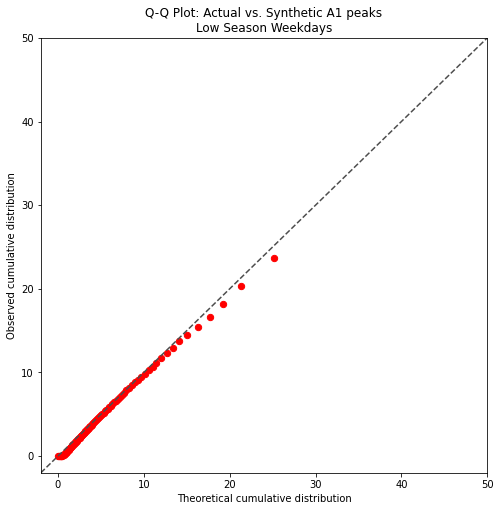

In [18]:
y_std,len_y,y = standarise(synth_A1,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 50], [-2, 50], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(synth_A1, percentile_bins)

percentile_cutoffs = np.percentile(act_A1, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic A1 peaks\nLow Season Weekdays') 
ax.set_xlabel('Theoretical cumulative distribution')
ax.set_ylabel('Observed cumulative distribution')
# ax.legend()
ax.set_ylim(-2,50)
ax.set_xlim(-2,50)
plt.show()

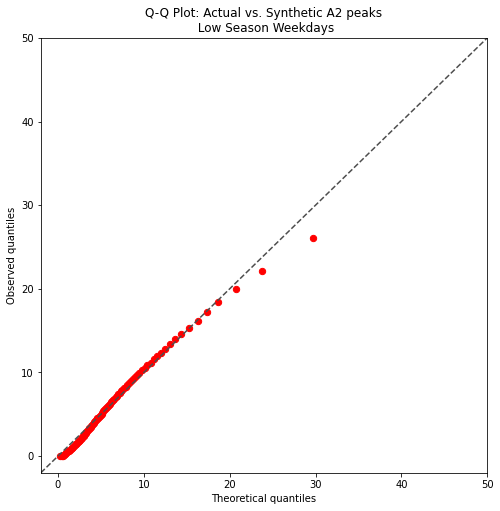

In [19]:
y_std,len_y,y = standarise(synth_A2,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 50], [-2, 50], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

percentile_cutoffs = np.percentile(act_A2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic A2 peaks\n Low Season Weekdays') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,50)
ax.set_xlim(-2,50)
plt.show()

# Total daily consumption

### High season weekends

In [47]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "High_season_weekends")

daily_energy_synth = Synth_Prof_HWeekend.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

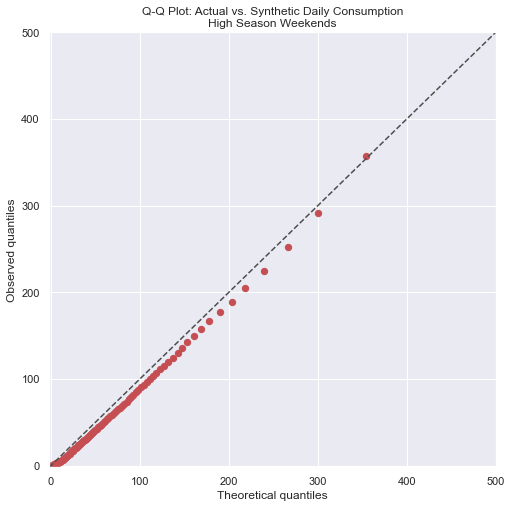

In [55]:
y_std,len_y,y = standarise(x1,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 800], [-2, 800], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(x1, percentile_bins)

percentile_cutoffs = np.percentile(x2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic Daily Consumption\nHigh Season Weekends') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,500)
ax.set_xlim(-2,500)
plt.show()

### HWeekdays

In [ ]:
HighSeason_weekdays, Low_season_weekdays, Low_season_weekends, High_season_weekends

In [57]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "HighSeason_weekdays")

daily_energy_synth = Synth_Prof_HWeekday.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

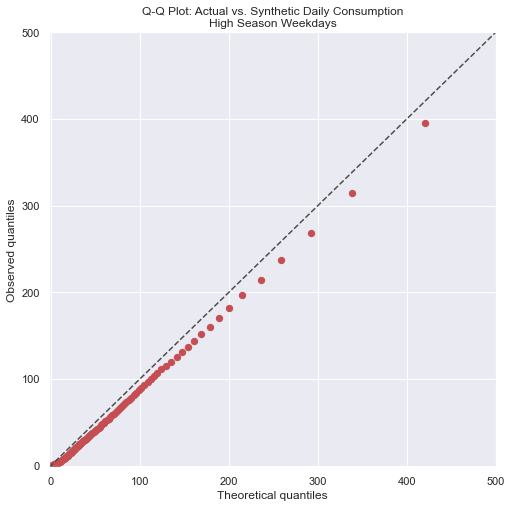

In [62]:
y_std,len_y,y = standarise(x2,0.99,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 800], [-2, 800], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(x1, percentile_bins)

percentile_cutoffs = np.percentile(x2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic Daily Consumption\nHigh Season Weekdays') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,500)
ax.set_xlim(-2,500)
plt.show()

### Low season Weekdays

In [67]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "Low_season_weekdays")

daily_energy_synth = Synth_Prof_LWeekday.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

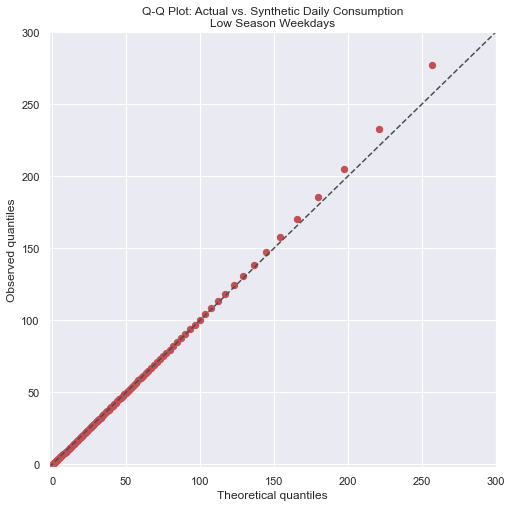

In [79]:
y_std,len_y,y = standarise(x2,0.996,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 300], [-2, 300], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

percentile_cutoffs = np.percentile(x2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic Daily Consumption\nLow Season Weekdays') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,300)
ax.set_xlim(-2,300)
plt.show()

### Low Season Weekends

In [80]:
cleaned_df, gaus_fit_features = get_FitFeatures(season = "Low_season_weekends")

daily_energy_synth = Synth_Prof_LWeekend.sum(axis = 1)
daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])
daily_energy_synth.reset_index(inplace = True)

new_df = cleaned_df.copy()
new_df.set_index(['ProfileID','date'], inplace = True)
new_df_sum = new_df.sum(axis = 1)
daily_energy_actual = pd.DataFrame(new_df_sum, columns = ['Daily Energy'])

# daily_energy_synth = synthetic_df.sum(axis = 1)
# daily_energy_synth = pd.DataFrame(daily_energy_synth, columns = ['Daily Energy'])

daily_energy_actual.reset_index(inplace = True)
# daily_energy_synth.reset_index(inplace = True)
daily_energy_synth_filtered = daily_energy_synth#.loc[daily_energy_synth.ProfileID.isin(profile_ids_good_fit),:]
daily_energy_actual_filtered = daily_energy_actual.loc[daily_energy_actual.ProfileID.isin(daily_energy_synth.ProfileID.unique()),:]

x1 = daily_energy_synth_filtered['Daily Energy']#*230/1000
x2 = daily_energy_actual_filtered['Daily Energy']#*230/1000

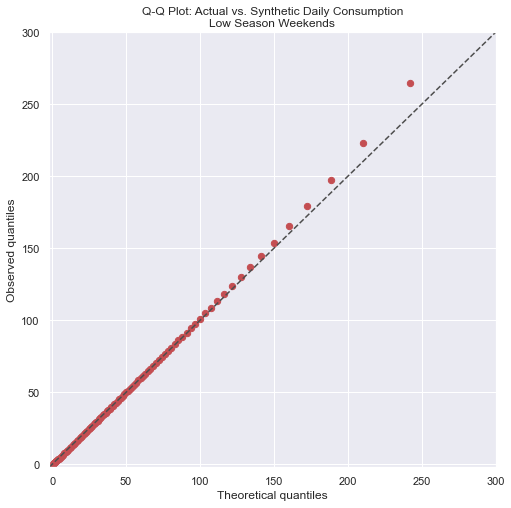

In [85]:
y_std,len_y,y = standarise(x2,0.995,0.01)

y_std = y

f, ax = plt.subplots(figsize=(8,8))
ax.plot([-2, 300], [-2, 300], ls="--", c=".3")

percentile_bins = np.linspace(0,100,100)
percentile_cutoffs1 = np.percentile(y_std, percentile_bins)

percentile_cutoffs = np.percentile(x2, percentile_bins)

ax.scatter(percentile_cutoffs1,percentile_cutoffs,c='r',s = 40)
ax.set_title('Q-Q Plot: Actual vs. Synthetic Daily Consumption\nLow Season Weekends') 
ax.set_xlabel('Theoretical quantiles')
ax.set_ylabel('Observed quantiles')
# ax.legend()
ax.set_ylim(-2,300)
ax.set_xlim(-2,300)
plt.show()